# An Examination of Trends in Film



<img src="hollywood.png" alt="Hollywood Sign" style="height:500px;width:800px;">

## Introduction

A journey to any theater to view a film, in a pre-pandemic world, was an experience for anyone willing. Take the time to immerse yourself in another world, another time, or another romance and let the world outside of the air conditioned screening rooms just melt away. These experiences can break ennui, provide artistic fulfillment, and be fun. 

On the other hand, however, film is a business. According to Forbes, in 2019 the film industry surpassed [$100 Billion USD](https://www.forbes.com/sites/rosaescandon/2020/03/12/the-film-industry-made-a-record-breaking-100-billion-last-year/#1e22642e34cd) in earnings. Therefore, if a formula can be cracked - or even a new formula devised - certain entities could stand to take a decent slice of this proverbial pie. 

We have selected the previous decade of film minus the current year due to industry changes related to the pandemic. This provides a relevant look at the film industry. Following this logic we have chose to focus on films produced domestically, but with international considerations. 

## Points of Analysis

### Optimal Budget

Looking deeper into the subject of film one of the obvious and most functionally useful questions to ask is: Does a higher budget, actually make more money?

### Most Profitable Rating

Ratings are an exclusionary system. Does this exclusivity block out a large sector of the market at the higher ratings, or does it entice them in?

### Profitability of Genre

Does a gun-totin' cowboy with a hearth of gold bring in the most box office dollars? Or is it the family friendly comedy produced by a large production company. We take a dive into genres across the decade to find what is on the up-trend and what is falling down. 

# Data Retrieval

<img src="matrix-code.jpg" alt="Matrix Digital Rain" style="height:300px;width:500px;">

## Libraries and Data Retrieval 

### Library Importations

In [147]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
import plotly
from plotly.subplots import make_subplots
import tmdbsimple as tmdb
import requests
from tqdm.notebook import tqdm
import pprint
import time
import csv

%matplotlib inline

## Opens API key
f = open('C:/Users/Nero_/apikeys/tmdb.txt', 'r')
key = f.readline()

tmdb.API_KEY = key

## Pretty print aestheics 
pp = pprint.PrettyPrinter(indent=2)

### Datasets and Retrieval

In [148]:
## If you would like to scrape, set scraping to True
scraping = False

## Creating an ID list to scrape with
discover = tmdb.Discover()

id_list = []

## For loop scrapes 500 pages of data to return the tmdb id of each
## entry for later use in scraping
if scraping:
    for pages in tqdm(range(1,501), desc='ID Append'):
        page = discover.movie(language='en-US', sort_by='revenue.desc', page=pages, 
                              certification_country='US', certification_lte='NC-17', 
                              certification_gte='G', primary_release_date_gte='2010-01-01', 
                              with_original_language='en')
        for film in page['results']:
            id_list.append(film['id'])
        time.sleep(.16)

In [149]:
## Movie info scraping function
def movie_info(list_id):
    
    """Movie Info Scraper_test.csv
       ---------------------------
       Function takes a list of The Movie Database Unique IDs
       and returns a dictionary of data that includes: title, release date,
       MPAA rating, IMDB_ID, TMDB_ID, running time, genres, budget, and revenue
       information. """
    
    ## Pulling tmdbsimple object methods and passing them into variables
    movie = tmdb.Movies(list_id).info()
    ratings = tmdb.Movies(list_id).release_dates()
    
    ## Search ratings variables for MPAA certification
    iso = 'iso_3166_1'
    for result in ratings['results']:
        if result[iso] == 'US':
            if result['release_dates'][0]['certification'] == '':
                rating = result['release_dates'][1]['certification']
            else: 
                rating = result['release_dates'][0]['certification']
    ## Sleep timer = No accidental DDoS
    time.sleep(.05)
    
    ## Dictionary to catch and store information requested
    movie_dict = {
        'title': movie['original_title'],
        'release_date': movie['release_date'],
        'rating': rating,
        'imdb_id': movie['imdb_id'],
        'tmbd_id': movie['id'],
        'runtime': movie['runtime'],
        'genres': [[genre.get('name') for genre in movie['genres']]],
        'budget': movie['budget'],
        'revenue': movie['revenue']
    }
    
    return movie_dict

In [150]:
## Scraping loop

## Initialize the list of dicts to store scraped data
film_dict = []

## For loop used to scrape using the scraping function with error handling for
## cases of HTTP errors.
if scraping:
    for movie in tqdm(id_list):
        try:
            film_dict.append(movie_info(movie))
        except:
            film_dict.append('Missing')

In [151]:
## Remove any missing entires in the list as well as removing
## empty values in two strings of the movie information

miss = 'Missing'
for count, film in enumerate(film_dict):
    if film == miss:
        film_dict.pop(count)
    if film_dict[count]['rating'] == '':
        film_dict.pop(count)
    if film_dict[count]['imdb_id'] == '':
        film_dict.pop(count)

In [152]:
## Convert the list of movie dicts into a pandas dataframe if scraping and save to CSV
if scraping:
    film = pd.DataFrame.from_records(film_dict)
    film.to_csv('film.csv', index=False)

In [153]:
## Read from CSV if not scraping
film = pd.read_csv('film.csv', converters={'genres':pd.eval})

## Convert the release_date column from an object (string) to a datetime object
film['release_date'] = pd.to_datetime(film['release_date'])

In [154]:
## Bring in previously scraped data and convert to dataframe
bomFrame = pd.read_csv('Scraper_test.csv')
bom_frame = pd.DataFrame(bomFrame)

In [155]:
## Removing unwanted zero values from the dataframe to provide a clearer picture
## of the data. 

## Working with a copy to protect the original from transformative work
film_copy = film.copy()

## Removing the unwanted zero values from budget, revenue, and runtime
indexNames = film_copy[film_copy['budget'] == 0].index
film_copy.drop(indexNames, inplace=True)

revenueNames = film_copy[film_copy['revenue'] == 0].index
film_copy.drop(revenueNames, inplace=True)

runtimeNames = film_copy[film_copy['runtime'] == 0].index
film_copy.drop(runtimeNames, inplace=True)

## Casting the tmbd_id as str to avoid any mathematical operations during
## further analysis steps.
film_copy['tmbd_id'] = film_copy['tmbd_id'].apply(str)
film_copy.drop(['revenue'], axis=1, inplace=True)

## Check the data for correct operations
print(film_copy.info())
display(film_copy.head())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1720 entries, 0 to 2188
Data columns (total 8 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   title         1720 non-null   object        
 1   release_date  1720 non-null   datetime64[ns]
 2   rating        1718 non-null   object        
 3   imdb_id       1696 non-null   object        
 4   tmbd_id       1720 non-null   object        
 5   runtime       1720 non-null   float64       
 6   genres        1720 non-null   object        
 7   budget        1720 non-null   int64         
dtypes: datetime64[ns](1), float64(1), int64(1), object(5)
memory usage: 120.9+ KB
None


,title,release_date,rating,imdb_id,tmbd_id,runtime,genres,budget
0,Avengers: Endgame,2019-04-24,PG-13,tt4154796,299534,181.0,"[[Adventure, Science Fiction, Action]]",356000000
1,Star Wars: The Force Awakens,2015-12-15,PG-13,tt2488496,140607,136.0,"[[Action, Adventure, Science Fiction, Fantasy]]",245000000
2,Avengers: Infinity War,2018-04-25,PG-13,tt4154756,299536,149.0,"[[Adventure, Action, Science Fiction]]",300000000
3,Jurassic World,2015-06-06,PG-13,tt0369610,135397,124.0,"[[Action, Adventure, Science Fiction, Thriller]]",150000000
4,The Lion King,2019-07-12,PG,tt6105098,420818,118.0,"[[Adventure, Family, Music]]",260000000


In [156]:
## Merging the partially cleaned film dataframe and the previously scraped data
merge = pd.merge(left=film_copy, right=bom_frame, left_on='title', right_on='Title')

In [157]:
## Dropping unwanted values from the newly merged dataset

## Dropping the extra Title column
merge = merge.drop(['Title'], axis=1)

## Removing zero and extraneous values from the newly merged dataframe
mergeRuntimes = merge[merge['runtime'] == 0].index
merge.drop(mergeRuntimes, inplace=True)

mergeOpen = merge[merge['Number_of_Opening_Theaters'] == '('].index
merge.drop(mergeOpen, inplace=True)

mergeOpen = merge[merge['Number_of_Opening_Theaters'] == 0].index
merge.drop(mergeOpen, inplace=True)

mergeBudget = merge[merge['budget'] == 0].index
merge.drop(mergeBudget, inplace=True)

In [158]:
## Casting the tmbd_id, runtime, and Number_of_Opening_Theaters columns
## as more useful datatypes for analysis.
merge = merge.astype({'tmbd_id':'object', 'runtime':'int64','Number_of_Opening_Theaters':'int64'})

In [159]:
## Dropping doubles that may have been introduced in the merge
merge = merge.sort_values('imdb_id', ascending=False)
merge = merge.drop_duplicates(subset='imdb_id', keep='first')

In [160]:
## Feature engineering
## Creating a profit column from Worldwide_Gross - budget
merge['Profit'] = merge['Worldwide_Gross'] - merge['budget']

In [161]:
## Checking the newly created column
merge

,title,release_date,rating,imdb_id,tmbd_id,runtime,genres,budget,Domestic_Gross,International_Gross,Worldwide_Gross,Opening_Gross,Number_of_Opening_Theaters,Profit
1175,Playing with Fire,2019-11-08,PG,tt9134216,554241,96,"[[Comedy, Family]]",29900000,44451847,24179822,68631669,12723781,3125,38731669
331,Knives Out,2019-11-27,PG-13,tt8946378,546554,131,"[[Mystery, Thriller, Comedy, Drama, Crime]]",40000000,165363234,143869563,309232797,26769548,3461,269232797
1143,Midsommar,2019-07-03,R,tt8772262,530385,148,"[[Horror, Drama, Mystery]]",9000000,27426361,20437004,47863365,6560030,2707,38863365
1152,21 Bridges,2019-10-24,R,tt8688634,535292,99,"[[Crime, Action, Drama]]",33000000,28539757,21400000,49939757,9261268,2665,16939757
1171,Child's Play,2019-06-19,R,tt8663516,533642,90,[[Horror]],10000000,29208403,15693834,44902237,14094594,3007,34902237
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1390,The Rum Diary,2011-10-13,R,tt0376136,23514,120,"[[Drama, Comedy]]",45000000,13109815,17025143,30134958,5135369,2273,-14865042
2,Jurassic World,2015-06-06,PG-13,tt0369610,135397,124,"[[Action, Adventure, Science Fiction, Thriller]]",150000000,652270625,1018130012,1670400637,208806270,4274,1520400637
1091,A Walk Among the Tombstones,2014-09-18,R,tt0365907,169917,113,"[[Crime, Drama, Mystery, Thriller]]",28000000,26307600,32526784,58834384,12758780,2712,30834384
520,The Secret Life of Walter Mitty,2013-12-18,PG,tt0359950,116745,114,"[[Adventure, Comedy, Drama, Fantasy]]",90000000,58236838,129896484,188133322,12765508,2909,98133322


In [162]:
merge['genres'] = merge['genres'].apply(lambda x: x[0])

# Data Analysis

<img src="hacker.jpg" alt="Hacker!" style="height:350px;width:500px;">

### Exploratory Data Analysis

After very minor feature engineering to pull out a basic profit calculation of each film by subtracting the `budget` from the `Worldwide_Gross` in the retrieval and cleaning process.

It is a good idea to look at the various values and to take note of any correlations between the values of the data. 

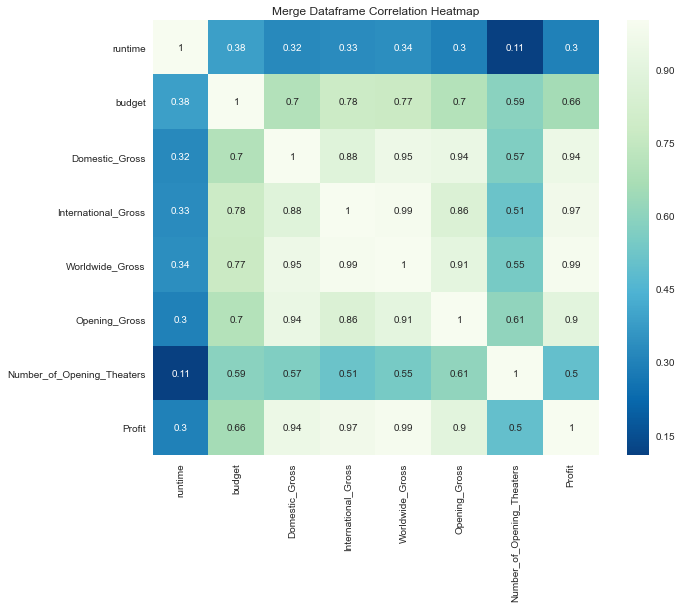

In [163]:
plt.figure(figsize=(10, 8))
plt.title('Merge Dataframe Correlation Heatmap')
mergeCorr = merge.corr()
sns.heatmap(mergeCorr, annot=True,cmap='GnBu_r')
plt.show()

This correlation heatmap is the perfect visual to display the correlations of values at a glance. The information gleamed here is valuable for further analysis. First, it can be surmised that variables with low correlation coefficients such as `runtime` to `Number_of_Opening_Theaters` are not information worth looking in to. On the other side of this issue are things with a very obvious correlation, such as `International_Gross` and `Worldwide_Gross` - it bears to reason that those few regions not included in `International_Gross` would follow with similar results. 

Some of the more interesting results that could bear further fruit in analysis would be things like how `budget` effects `runtime` or what the relationship between something like `domestic_gross` and `opening_gross` is. 

### How profitable is a movie?

A determination on what kind of movie to make hinges on the profitability of a movie, and it is important to determine exactly how profitable a movie is. To do this there must be a measure more of feature engineering. We are going to determine a basic Return on Investment.

$$ \frac{Profit}{Worldwide Gross} X 100 = ROI Percent$$

In [164]:
merge_profit = merge['Profit']
merge_WWGross = merge['Worldwide_Gross']
percent_profit = round(merge_profit/merge_WWGross, 3)*100

merge.loc[:,'ROI'] = percent_profit

Using a mathematical determination of the profitability it is easier to surmise what will make a film profitable. Taking this measure of profitability it is much easier to sift through the data. Further, a step is taken to eliminate further extraneous data by setting the budget to a figure no less than $10,000. 

In [165]:
top_100 = merge.sort_values(by='ROI', ascending=False)
print(len(top_100))
top_100 = top_100[top_100['budget'] >= 10000]
print(len(top_100))
display(top_100.head())

1547
1541


,title,release_date,rating,imdb_id,tmbd_id,runtime,genres,budget,Domestic_Gross,International_Gross,Worldwide_Gross,Opening_Gross,Number_of_Opening_Theaters,Profit,ROI
144,Logan,2010-09-10,G,tt1483010,44010,94,"[Comedy, Drama, Family]",135000,226277068,392744368,619021436,88411916,4071,618886436,100.0
1973,Arrival,2018-12-20,PG-13,tt8259442,696430,56,[Adventure],10000,100546139,102842047,203388186,24074047,2317,203378186,100.0
1196,The Gallows,2015-07-10,R,tt2309260,299245,87,"[Horror, Thriller]",100000,22764410,20200000,42964410,9808463,2720,42864410,99.8
153,Fifty Shades of Grey,2015-02-11,R,tt2322441,216015,125,"[Drama, Romance, Thriller]",4000000,166167230,403484237,569651467,85171450,3646,565651467,99.3
1768,Catfish,2010-09-17,PG-13,tt1584016,42296,87,[Documentary],30000,3237343,296368,3533711,257285,12,3503711,99.2


Taking a look at some of the most profitable films using the Profitability Percentage metric will allow deeper insights to be drawn into what exactly makes a film profitable. The first conclusion that can be drawn is that there is an optimum budget range that will produce the most profit.

## Optimal Budget to Maximize Profit

<img src="money_header.jpg" alt="MONEY!" style="width:500px;height:300px;">

Looking at the plot below it can be surmised that the the distribution of the data has a strongly positive skew. Taking this information and comparing it to a scatter plot will allow for further derivation of further insights to confirm ideas that can be drawn from the data. 

The scatter plot reveals a large cluster of data and betrays the few outliers that trail at the tail of the data. Working with his information an inference can be made about where our optimal budget may be derived from. This ends can be achieved with the use of a regression line, mean estimation, and confidence intervals to look where the data is most useful for estimation of the optimal budget.

AttributeError: 'function' object has no attribute 'set_major_formatter'

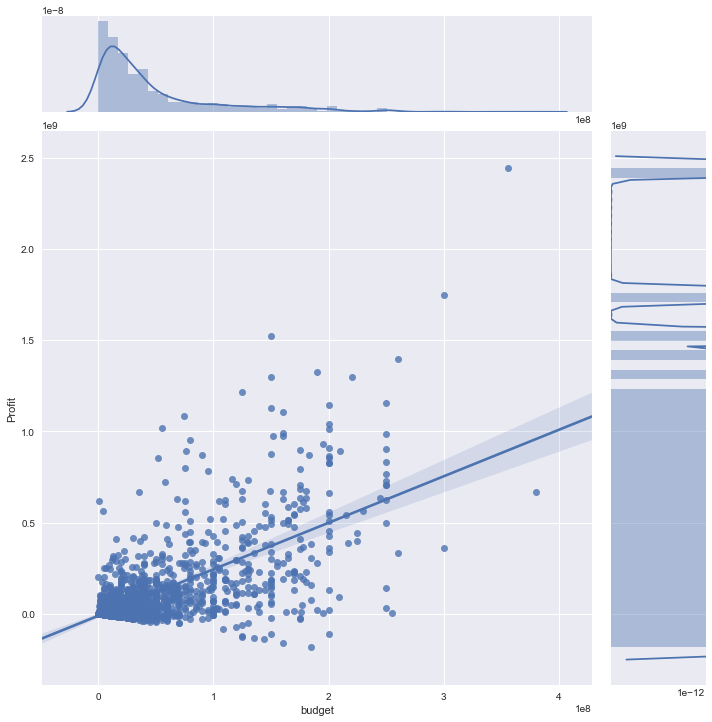

In [196]:
## Create boxplot/scatterplot in plotly express
fig = make_subplots(rows=2, cols=1)

fig = px.scatter(x='budget', y='Profit', data_frame=top_100,
                 title="Budget vs Profit Distribution with Profit and Budget Boxplots", 
                 hover_data=['title'], marginal_x='box', marginal_y='box',
                 width=1000, height=700)
fig.show()

## Create and manage regplot with Seaborn
# plt.figure(figsize=(10, 6))

# plt.ticklabel_format(axis='both', style='plain')
# plt.title('Budget vs. Profit \n Regression Plot with Confidence Intervals', fontsize=13)
# ax = sns.regplot(x='budget', y='Profit', data=top_100, fit_reg=True, x_bins=10, x_ci='ci')
ax = sns.jointplot("budget", "Profit", data=top_100, kind="reg", height=10)

# fmt = '${x:,.0f}'
# tick = mtick.StrMethodFormatter(fmt)
ax.ax_joint.set_xticks.set_major_formatter(tick)
# ax.yaxis.set_major_formatter(tick)
# plt.xticks(rotation=90)

plt.style.use('seaborn')
plt.show()
plt.savefig('regplot.png')


In [167]:
## Creates numerical quantiles and mean to print
quant_50 = top_100['budget'].quantile()
quant_25 = top_100['budget'].quantile(.25)
quant_75 = top_100['budget'].quantile(.75)
mean = top_100['budget'].mean()


print(' Mean:', round(mean, 2),'\n','Lower Quartile :', quant_25, '\n', 'Median: ', quant_50, 
      '\n', 'Upper Quartile: ', quant_75)

 Mean: 47927170.1 
 Lower Quartile : 10000000.0 
 Median:  27000000.0 
 Upper Quartile:  60000000.0


Now that a visualization has been established to make sense of the data it is time to look into the relationship of the data.

This can be seen as a linear relationship between the budget and the profit. It can be confidentally assumed that, even given  films with negative profits, a profit can be turned if a sufficient budget is provided.

## Most Profitable MPAA Rating

### A Background on Ratings

Ratings systems are put in place to provide guidance to individuals on the content of film. There are several categories that represent the different contents and advisories from the MPAA. The ratings are as follows:

<img src="mpaaratings.png" alt="MPAA Ratings">

[Image Source](https://en.wikipedia.org/wiki/Motion_Picture_Association_film_rating_system)

**Note:** Films can also be unrated if they have yet to be rated or refuse rating. 

### An Examination of Profitability of Various Ratings

It can be useful to look at the distribution of budgets vs. profit of a relevant sample of the data. With this in mind, we can look back at a previous graphic with some updated information. 

In [182]:
## Extract the top 100 films sorted by profit
top100 = top_100.sort_values(by='Profit', ascending=False)
#top100 = top100.head(100) 
merge.head()

,title,release_date,rating,imdb_id,tmbd_id,runtime,genres,budget,Domestic_Gross,International_Gross,Worldwide_Gross,Opening_Gross,Number_of_Opening_Theaters,Profit,ROI
1175,Playing with Fire,2019-11-08,PG,tt9134216,554241,96,"[Comedy, Family]",29900000,44451847,24179822,68631669,12723781,3125,38731669,56.4
331,Knives Out,2019-11-27,PG-13,tt8946378,546554,131,"[Mystery, Thriller, Comedy, Drama, Crime]",40000000,165363234,143869563,309232797,26769548,3461,269232797,87.1
1143,Midsommar,2019-07-03,R,tt8772262,530385,148,"[Horror, Drama, Mystery]",9000000,27426361,20437004,47863365,6560030,2707,38863365,81.2
1152,21 Bridges,2019-10-24,R,tt8688634,535292,99,"[Crime, Action, Drama]",33000000,28539757,21400000,49939757,9261268,2665,16939757,33.9
1171,Child's Play,2019-06-19,R,tt8663516,533642,90,[Horror],10000000,29208403,15693834,44902237,14094594,3007,34902237,77.7


In [187]:
## Keep this plot for presentation

fig = px.scatter(x='budget', y='Profit', data_frame=merge.dropna(),
                 title="Budget Distribution with Color by Rating", color='rating', 
                hover_data=['title', 'ROI'], facet_col='rating', trendline='ols', facet_col_wrap=3)
fig.show()

Looking deeper into the data it is possibly to draw some further insights. We have the Return on Investment of the top 100 films by rating as sorted by highest Profit.

In [170]:
## Barplot Generation

## Ratings profit
r_profit = round(top_100[top_100['rating'] == 'R']['ROI'].head(100).median(), 2)
pg13_profit = round(top_100[top_100['rating'] == 'PG-13']['ROI'].head(100).median(), 2)
pg_profit = round(top_100[top_100['rating'] == 'PG']['ROI'].head(100).median(), 2)
g_profit = round(top_100[top_100['rating'] == 'G']['ROI'].head(100).median(), 2)

## Ratings budgets
r_budget = round(top_100[top_100['rating'] == 'R']['budget'].head(100).median(), 2)
pg13_budget = round(top_100[top_100['rating'] == 'PG-13']['budget'].head(100).median(), 2)
pg_budget = round(top_100[top_100['rating'] == 'PG']['budget'].head(100).median(), 2)
g_budget = round(top_100[top_100['rating'] == 'G']['budget'].head(100).median(), 2)

## Figure size
plt.figure(figsize=(10,8))

## Figure variables and Data lists
ratings_profit = [r_profit, pg13_profit, pg_profit, g_profit]
ratings_budget = [r_budget, pg13_budget, pg_budget, g_budget]
x = ['R', 'PG-13', 'PG', 'G']

fig = px.bar(data_frame=top_100, x=x, y=ratings_profit, color=x,
             labels={'x':'Ratings', 'y':'Median ROI'}, template='ggplot2')
fig.show()

<Figure size 720x576 with 0 Axes>

In [171]:
## Top 100 films of each rating
r_rating = top_100[top_100['rating'] == 'R'].head(100)
pg13_rating = top_100[top_100['rating'] == 'PG-13'].head(100)
pg_rating = top_100[top_100['rating'] == 'PG'].head(100)
g_rating = top_100[top_100['rating'] == 'G'].head(100)


## Creating the subplot figure for plotly
fig = make_subplots(
    rows=2, cols=2,
    subplot_titles=('R - Budget vs Profit', 'PG-13 - Budget vs Profit', 'PG - Budget vs Profit',
                    'G - Budget vs Profit'))

## Creating each scatter for the subplot
fig.add_trace(go.Scatter(x=r_rating['budget'], y=r_rating['Profit'], 
                         mode='markers', name='R', hovertext=r_rating['title']), 
                         row=1, col=1)

fig.add_trace(go.Scatter(x=pg13_rating['budget'], y=pg13_rating['Profit'], 
                         mode='markers', name='PG-13', hovertext=pg13_rating['title']), 
                         row=1, col=2)

fig.add_trace(go.Scatter(x=pg_rating['budget'], y=pg_rating['Profit'], 
                         mode='markers', name='PG', hovertext=pg_rating['title']), 
                         row=2, col=1)

fig.add_trace(go.Scatter(x=g_rating['budget'], y=g_rating['Profit'], 
                         mode='markers', name='G', hovertext=g_rating['title']), 
                         row=2, col=2)

## Fixing the X and Y axes
fig.update_xaxes(title_text="Budget", row=1, col=1)
fig.update_xaxes(title_text="Budget", row=1, col=2)
fig.update_xaxes(title_text="Budget", row=2, col=1)
fig.update_xaxes(title_text="Budget", row=2, col=2)

fig.update_yaxes(title_text="Profit", row=1, col=1)
fig.update_yaxes(title_text="Profit", row=1, col=2)
fig.update_yaxes(title_text="Profit", row=2, col=1)
fig.update_yaxes(title_text="Profit", row=2, col=2)

## Updating the layout information
fig.update_layout(height=800, width=1000,
                  title_text="Budget vs Profit by Rating")

fig.show()

Narrowing the purview of the analyses helps to focus in the data, giving us solid recommendations for what films are likely to produce the greatest Return on Investment.

R rated films are the highest and PG-13 rated films are very marginally behind them. While the R rated films provide the general highest Return on Investment, PG-13 films offer the highest potential audience for the film and therefore a greater higher monetary return. 

## Return on Investment and Profit by Genre

In [172]:
## Creates an entry for each genre in a list of a given film's genres column
top100_genre = top_100.explode('genres')
## Creates a separate year column
top100_genre['year'] = top100_genre['release_date'].dt.year

In [173]:
## Group films by year and genre
top100group = top100_genre.groupby(['genres', 'year']).describe()

In [174]:
## Creates a list of genres
genrelist = top100_genre['genres'].unique()
## List of years for for-loop
years =  [2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017, 2018, 2019]

## Lists to append to for later zip
glist = []
mlist = []
ylist = []

## For loop to loop through year and genre to get median profit
for year in years:
    df = top100_genre[top100_genre['release_date'].dt.year == year]
    for film_genre in genrelist:
        gendf = df[df['genres'] == film_genre]
        medtest = gendf['Profit'].median()
        glist.append(film_genre)
        ## Checks for nan values, assigns value as zero
        if medtest == np.nan:
            mlist.append(0)
        else:
            mlist.append(medtest)
        ylist.append(year)
    

## Zips lists together to create a dataframe
newdf = pd.DataFrame(list(zip(ylist, glist, mlist)),
              columns=['Year','Genre', 'Median_Profit'])

## Create the multi-faceted bar graph
fig = px.line(newdf, x='Year', y='Median_Profit', facet_col='Genre', facet_col_wrap=4,
              facet_row_spacing=.1, color='Genre',
              title='Median Profit Per Year by Genre', labels={'y':'Median Profit'}, height=800, width=1000)

fig.show()

There are a few ways that the data could be interpreted. Rarely will a film fall into a single genre, especially if the film is an animation of some sort. It is apt of us to look at a range of top genres to provide strong genre combinations that make sense, and more importantly make money. 

The presented visualization makes it obviously clear which genres are on the uptrend as far as median profit goes. Therefore it is recommended that one of the genres for the film be Adventure. Following this the second genre could be a ranging pick of either family, science fiction, or fantasy - though family seems to be a growing category.

Therefore we would recommend the film to be made as a family action movie.

# Conclusion

Our observations are abundantly clear. 

Yes, a film will make more money if you spend more money on it, but there are diminishing returns unless you're one of the lucky blockbuster mega-hits.

The relatively small margin between R and PG-13 rated films puts us squarely in the camp of recommending PG-13 films. These films can be more family friendly and open to all comers than an R rated film - thus expanding the audience. 

Finally, with several major blockbuster franchises going the route of an Action-Adventure film, that is what the public wants. Pair it with science fiction, or make it an animated family film to hit a few other major demographics.